In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import load_digits
from sklearn.base import clone 
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import RandomForestClassifier


from random import randint

### Class-wise data exploration

In [2]:
# Get Data from File
csv_filename = "qc aggregated data.csv"
df = pd.read_csv(csv_filename)

# Specify Input and Output from Data
input_columns = ["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed"]
output_column = ["conditions"]
df = df[input_columns + output_column]

max_count = 0
all_conditions = list(df.conditions.unique())

for condition in df.conditions.unique():
    num_per_class = len(df[df.conditions == condition])
    print(f"{condition} : {num_per_class}")
    if num_per_class > max_count:
        max_count = num_per_class

new_data = []

for condition in df.conditions.unique():
    num_per_class = len(df[df.conditions == condition])
    t_l = df[df.conditions == condition].to_numpy().tolist()
    print(condition)
    print(len(t_l), num_per_class, max_count-len(t_l))
    for rem in range(max_count-len(t_l)):
        t_l.append(t_l[randint(0, num_per_class)])

    new_data.extend(t_l)
    print(len(t_l), num_per_class, max_count-len(t_l), "New Data Len: ", len(new_data))

new_data = np.array(new_data)

Y = new_data[:, len(new_data[0])-1]
X = new_data[:, :len(new_data[0])-1]

In [2]:
def run(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    r_forest = RandomForestClassifier(verbose=0)
    learning_rate = 0.001
    total_units = 64
    total_epochs = 25
    batch_size = 32

    # RBM
    rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)


    model = Pipeline(
        steps = [
            ('rbm1', clone(rbm)),
            ('rbm2', clone(rbm)),
            ('rfc', clone(r_forest))
        ]
    )

    model.fit(X_train, Y_train)

    # Predict on training (for verification)
    Y_pred_train = model.predict(X_train)
    CM_train = confusion_matrix(Y_pred_train, Y_train)
    train_acc = accuracy_score(Y_train, Y_pred_train)

    # Testing Plot
    plt.figure(figsize=(15, 4))
    ax = plt.subplot(121)
    ax.set_title("Training - Confusion Matrix")
    sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
    plt.yticks(rotation=0)

    # Predict on testing (for verification)
    Y_pred_test = model.predict(X_test)
    CM_test = confusion_matrix(Y_pred_test, Y_test)
    test_acc = accuracy_score(Y_test, Y_pred_test)

    ax2 = plt.subplot(122)
    ax2.set_title("Testing - Confusion Matrix")
    sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
    plt.yticks(rotation=0)

    plt.show()
    print(f"Testing: {test_acc} \nTraining: {train_acc}")

### MNIST Experimentation - No Augmentation

In [23]:
A = load_digits(n_class=5)
X = A.data 
Y = A.target 
X = (X - np.min(X)) / np.max(X)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -41.75, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -39.47, time = 0.02s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -37.67, time = 0.02s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -36.30, time = 0.02s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -35.20, time = 0.02s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -33.20, time = 0.02s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -32.88, time = 0.02s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -32.24, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -31.81, time = 0.02s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -30.67, time = 0.02s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -30.44, time = 0.02s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -29.87, time = 0.02s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -29.03, time = 0.02s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -28.69, time = 0.03s
[BernoulliRBM] Iteration 15, 

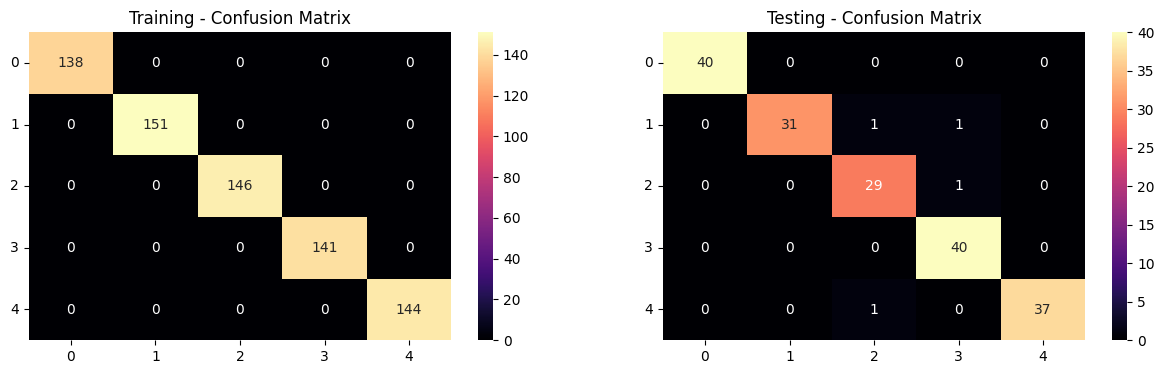

Testing: 0.9779005524861878 
Training: 1.0


In [24]:
run(X, Y)

### MNIST Experimentation

In [14]:
a = load_digits(n_class=5)
X = a.data
Y = a.target
reshape_width = 8
new_X = []
new_Y = []
for idx, el in enumerate(X):

    pad_bounds = reshape_width // 2
    res_array = np.reshape(el, (reshape_width, reshape_width))

    # Padded - Normal
    padded_arr = np.pad(res_array, pad_width=pad_bounds)
    new_X.append(padded_arr.flatten())
    new_Y.append(Y[idx])
    #print(padded_arr)

    # Padded - Shifted - Horizontal
    for shift in range(-1 * (pad_bounds), pad_bounds + 1, 1):
        shifted_padded_arr = np.roll(padded_arr, shift)

        for v_shift in range(-1 * (pad_bounds), pad_bounds + 1, 1):
            sp_a = np.zeros((reshape_width * 2, reshape_width * 2))

            #print(sp_a.shape)

            for x in range(reshape_width * 2): 
                sp_a[:, x] = np.roll(shifted_padded_arr[:, x], v_shift)

            # Rotation
            '''
            for y in range(4):
                sp_a_r = np.rot90(sp_a, y)
                new_X.append(sp_a_r.flatten())
                new_Y.append(Y[idx])
                print(idx, "/", len(X), y)
            '''

            # Simple Move
            new_X.append(sp_a.flatten())
            new_Y.append(Y[idx])
            print(idx, "/", len(X))
    



len(X), len(Y), len(new_X), len(new_Y), len(new_X) / len(new_Y)


0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
0 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901
1 / 901


(901, 901, 73882, 73882, 1.0)

In [20]:
X_t = (new_X - np.min(new_X)) / np.max(new_X)
Y_t = np.array(new_Y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -65.25, time = 5.32s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -51.90, time = 7.12s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -50.42, time = 6.16s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -49.83, time = 6.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -46.85, time = 6.74s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -45.41, time = 5.77s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -43.83, time = 7.77s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -42.98, time = 5.91s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -40.93, time = 6.10s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -39.45, time = 5.50s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -37.42, time = 6.20s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -36.85, time = 6.00s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -36.01, time = 6.49s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -34.38, time = 7.07s
[BernoulliRBM] Iteration 15, 

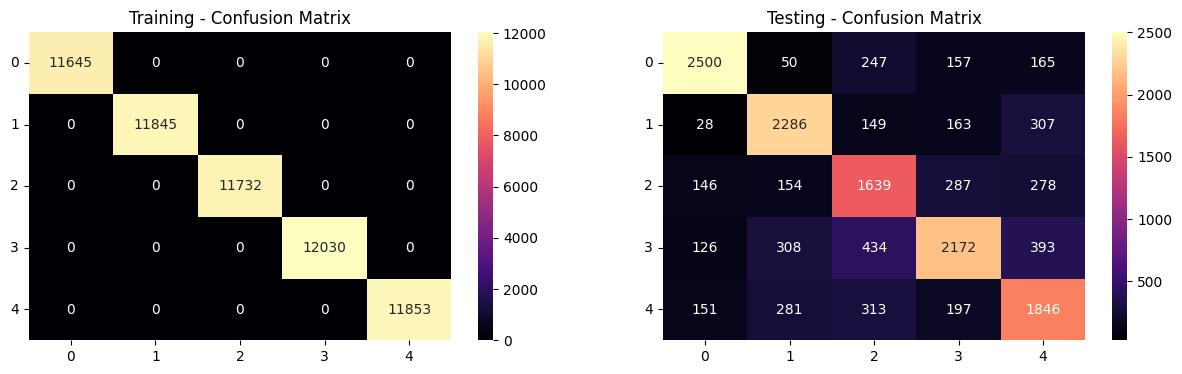

Testing: 0.7067063680043311 
Training: 1.0


In [22]:
run(X_t, Y_t)